In [7]:
# Basic Imports
import pathlib
from pathlib import Path
import os
import sys
from typing import Any, Sequence, Optional, Tuple, Iterator, Dict, Callable, Union
import json
import time
from tqdm.auto import tqdm
import numpy as np
from copy import copy
from glob import glob
from collections import defaultdict
import matplotlib.pyplot as plt

# Changing fonts to be latex typesetting
from matplotlib import rcParams
rcParams['mathtext.fontset'] = 'dejavuserif'
rcParams['font.family'] = 'serif'

# JAX/Flax
import jax
import jax.numpy as jnp
from jax import random
import flax
from flax import linen as nn
from flax.training import train_state, checkpoints
import optax

# For ODESolver
from scipy import integrate

# PyTorch for Dataloaders
import torch
from torch.utils.data import TensorDataset, DataLoader, Dataset

# Path to import created files
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path+"/src")

# Import created functions
from data import make_dataset as mkds
from visualization import visualize as vis

In [8]:
rng = random.PRNGKey(42)

x = mkds.rho(rng, 300)

x, train_samps = mkds.perturb(batchsize=10000,
                    rng = rng,
                    sigma = 0.01, 
                    tau = 0.03, 
                    M = 291,
                    restrict_M = True)

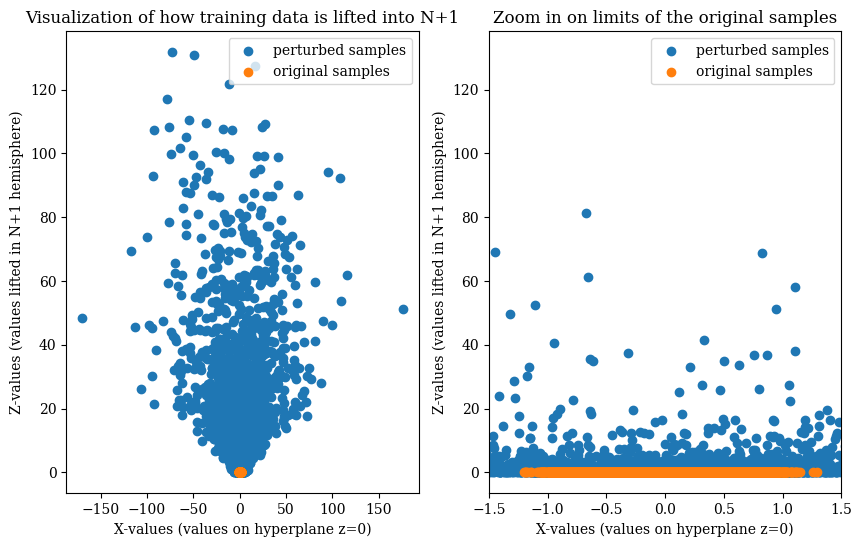

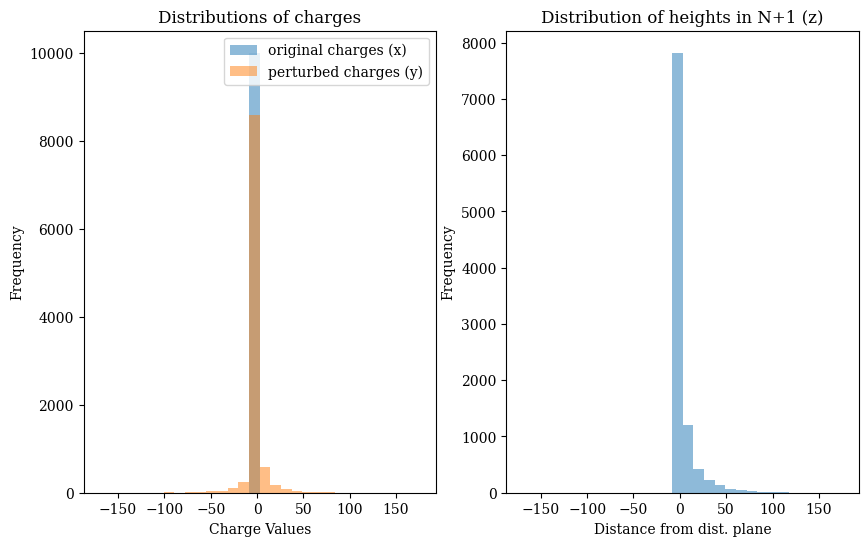

In [9]:
vis.perturb_vis(batchsize=10000, rng=rng)
vis.perturbed_dist_vis(batchsize=10000, rng=rng)

(1000, 2)
(1000, 2)


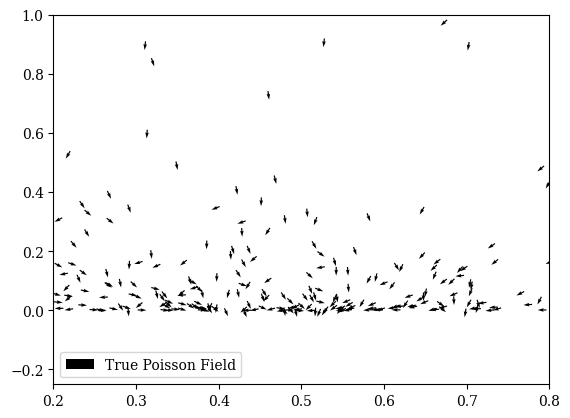

In [10]:
x, y = mkds.perturb(batchsize=1000,
                    rng = rng,
                    sigma = 0.01, 
                    tau = 0.03, 
                    M = 291,
                    restrict_M = True)
E = mkds.empirical_field(x, y)


limit = 1

print(y.shape)
print(E.shape)
plt.quiver(y[:,0], y[:,1], E[:,0], E[:,1], label='True Poisson Field');
plt.ylim(-0.25,limit)
plt.xlim(.2, .8)
plt.legend()
plt.show()

In [11]:
# train_data = get_NN_data(rng, samplesize=4, save=False, filename='')
# val_data = get_NN_data(rng, samplesize=4, save=False, filename='')

# y, E = train_data[0], train_data[1]
# vy, vE = val_data[0], val_data[1]
# print(y)
# print(vy)

In [12]:
# Create two instances of creating data due to running out of memory when go above
# samplesize of 35,000
train1_data = mkds.get_NN_data(rng, samplesize=35000, save=False, filename='')
train2_data = mkds.get_NN_data(rng+1, samplesize=35000, save=False, filename='')
# Collect the training data (y) & training labels (E)
train_y = jnp.concatenate((train1_data[0], train2_data[0]), axis=0)
train_E = jnp.concatenate((train1_data[1], train2_data[1]), axis=0)
# Put them into the format that save_gen_data expects
train_data = (train_y, train_E)
# Save data
mkds.save_gen_data(filename='train_data', data=train_data)
mkds.get_NN_data(rng+2, samplesize=8750, save=True, filename='val_data')
mkds.get_NN_data(rng+3, samplesize=8750, save=True, filename='test_data')


# print('y =', train_data[0][:,0])
# print('E =', train_data[0][:,1])
# plt.scatter(train_data[0][:,0], train_data[0][:,1])

(DeviceArray([[-1.8615232 ,  0.37534666],
              [-0.7797723 ,  0.6683701 ],
              [-1.7200202 ,  0.374124  ],
              ...,
              [ 0.42005703,  0.03115175],
              [ 0.4668918 ,  0.02504616],
              [ 0.6287976 ,  0.01852009]], dtype=float32),
 DeviceArray([[ 1.3565139 , -0.3998376 ],
              [ 0.5757981 , -1.2916874 ],
              [ 1.3705368 , -0.34875253],
              ...,
              [ 0.9575236 , -1.0407442 ],
              [-1.1953238 , -0.7557782 ],
              [-1.38786   , -0.27174357]], dtype=float32))